# Kullback-Leibler divergence

This reading will review the definition of the Kullback-Leibler (or KL) divergence, look at some of its important properties, see how it can be computed in practice with TensorFlow Probability.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)

# Additional packages for the reading
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

TF version: 2.1.0
TFP version: 0.9.0


## Introduction

As you have already seen, the KL divergence is used in variational inference to score the dissimilarity between two distributions. In this reading, we will examine KL divergence more closely. We will see the definition of the KL divergence and some important properties, as well as how it can be computed using `tfd.kl_divergence` and Monte Carlo estimation.

## Definition of the Kullback-Leibler divergence

Given two probability density or mass functions $q(x)$ and $p(x)$, the Kullback-Leibler divergence between them is defined as

\begin{equation}
    D_{KL}\big[q \ || \ p\big] =\begin{cases}
                                        \text{E}_{X\sim q}\big[
                                           \log q(X) - \log p(X)\big] &\text{if } p(x) = 0 \implies q(x) = 0,\\
                                        \infty &\text{otherwise.}
                                       \end{cases}
\end{equation}

The condition $p(x) = 0 \implies q(x) = 0$ - _absolute continuity_ - ensures that the $\log$ in the expectation is well-defined for all $x$ in the support of $q$. 

As was mentioned, the KL divergence is a score for the disagreement of two distributions in their placement of probability mass. A smaller score indicates a greater degree of agreement. 

## Properties

The Kullback-Leibler divergence is asymmetric. In general,

\begin{equation}
    D_{KL}\big[q \ || \ p\big] \neq D_{KL}\big[p \ || \ q \big]
\end{equation}

In variational inference, $q$ is the approximating distribution, while $p$ is the distribution being approximated. The other KL divergence - $D_{KL}[p \ || \ q  ]$ - is also sometimes used as a loss function, for reasons that will become clear later in this reading. 



### Gibbs' inequality

A crucial property of the KL divergence is that for all $q$ and $p$,

\begin{equation}
    D_{KL}\big[q \ || \ p\big] \geq 0,
\end{equation}

with equality if and only if $q(x) = p(x)$ almost everywhere. This property is very useful when we are trying to learn a $q$ that is similar to a $p$: if $D_{KL}[q \ || \ p] = 0$, then we know that $q$ is identical to $p$.

### What causes KL divergence to increase?

As an example, take $q(x)$ and $p(x)$ to be probability mass functions, and let $\mathcal{X}$ be $q$'s support. Provided $q$ is absolutely continuous with respect to $p$, we have

\begin{equation}
    D_{KL}\big[q \ || \ p\big] = \sum_{x \in \mathcal{X}} q(x) \log \frac{q(x)}{p(x)}.
\end{equation}

Values of $x$ that $p$ assigns mass to but $q$ does not do not feature in this sum. Superficially, this may suggest that divergence is not increased if $q$ fails to place mass where $p$ does. However, $q$ is a probability mass function, so will inevitably place more mass than $p$ at some other value(s) of $x$. At those other locations, $\log q(x)/p(x) > 0$, so the divergence is increased.

On the other hand, if $q$ places probability mass where $p$ does not, then $D_{KL}\big[q \ || \ p\big]$ is $+\infty$ - the KL divergence severely penalizes $q$ for locating probability mass where $p$ does not!

From this combination of effects, we can conclude that

\begin{equation}
    \text{support}(q) \subseteq \text{support}(p) \implies D_{KL}\big[ q \ || \ p \big] < \infty,
\end{equation}

while

\begin{equation}
    \text{support}(p) \subset \text{support}(q) \implies D_{KL}\big[ q \ || \ p \big] = \infty
\end{equation}

Consequently, the KL divergence favours distributions $q$ that have a support contained in the target distribution's (i.e. $p$'s).

The diagram below illustrates how the KL divergence is affected by the support of two bivariate density functions $q$ and $p$. The hatched regions indicate the support of either function.

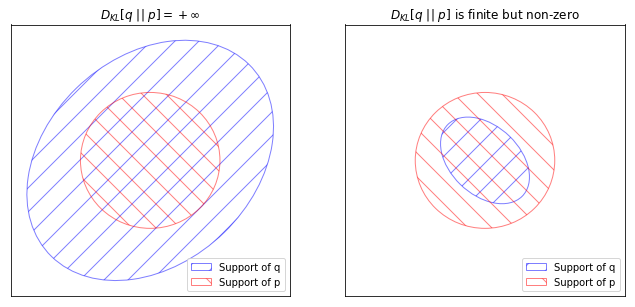

In [2]:
_, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11, 5))

delta = 45.0  # degrees

q_ell_inf = Ellipse((0, 0), 2, 1.5, 45, ec='blue', fc='none',
                    alpha=0.5, label='q(x)', hatch='/')
q_ell_fin = Ellipse((0, 0), 0.5, 0.75, 45, ec='blue', fc='none',
                    alpha=0.5, label='q(x)', hatch='/')
p_ell_inf = Ellipse((0, 0), 1, 1, 45, ec='red', fc='none',
                    alpha=0.5, label='p(x)', hatch='\\')
p_ell_fin = Ellipse((0, 0), 1, 1, 45, ec='red', fc='none',
                    alpha=0.5, label='p(x)', hatch='\\')

# KL divergence is infinite
for ell in [q_ell_inf, p_ell_inf]:
    axs[0].add_artist(ell)
axs[0].legend([q_ell_inf, p_ell_inf], ['Support of q', 'Support of p'], loc='lower right')
axs[0].get_xaxis().set_ticks([])
axs[0].get_yaxis().set_ticks([])
    
# KL divergence is finite
for ell in [q_ell_fin, p_ell_fin]:
    axs[1].add_artist(ell)
axs[1].legend([q_ell_fin, p_ell_fin], ['Support of q', 'Support of p'], loc='lower right')
axs[1].get_xaxis().set_ticks([])
axs[1].get_yaxis().set_ticks([])

axs[0].set_title(r'$D_{KL}[q \ || \ p] = +\infty$')
axs[1].set_title(r'$D_{KL}[q \ || \ p]$ is finite but non-zero')
plt.xlim(-1, 1)
plt.ylim(-1, 1);

## Computing KL divergence in TensorFlow

For some choices of $q$ and $p$, the KL divergence can be evaluated to a closed-form expression.

`tfd.kl_divergence` computes the KL divergence between two distributions analytically, provided the divergence in question has been implemented in the TensorFlow Probability library.

Below is an example that uses `tfd.kl_divergence` to compute $D_{KL}\big[q \ || \ p \big]$ when $q$ and $p$ are univariate normal distributions.

In [3]:
# Simple example

mu_q = 0.
sigma_q = 1.
mu_p = 0.
sigma_p = 0.5
distribution_q = tfd.Normal(loc=mu_q, scale=sigma_q)
distribution_p = tfd.Normal(loc=mu_p, scale=sigma_p)

tfd.kl_divergence(distribution_q, distribution_p) # D_{KL}[q || p]

<tf.Tensor: shape=(), dtype=float32, numpy=0.8068528>

Let's check this value. The KL divergence between two univariate normal distributions can be derived directly from the definition of the KL divergence as

\begin{equation}
    D_{KL}\big[ q \ || \ p\big] = \frac{1}{2}\bigg(\frac{\sigma_q^2}{\sigma_p^2} + \frac{(\mu_q - \mu_p)^2}{\sigma_p^2}  + 2\log \frac{\sigma_p}{\sigma_q} - 1\bigg)
\end{equation}

The value of this function should be equal to that returned by `kl_divergence(distribution_q, distribution_p)`. 

In [4]:
# Analytical expression for KL divergence between two univariate Normals

0.5*( (sigma_q/sigma_p)**2 + ((mu_q - mu_p)/sigma_p)**2 + 2*np.log(sigma_p/sigma_q) - 1)

0.8068528194400546

Sure enough, it is.

If a batch of distributions is passed to `kl_divergence`, then a batch of divergences will be returned. `kl_divergence` also supports broadcasting.

In [5]:
# Batch example with broadcasting

distributions_q = tfd.Normal(loc=[0., 1.], scale=1.)
distribution_p = tfd.Normal(loc=0., scale=0.5)

In [6]:
# Notice the batch_shape

distributions_q 

<tfp.distributions.Normal 'Normal' batch_shape=[2] event_shape=[] dtype=float32>

In [7]:
# [D_{KL}[q_1 || p], D_{KL}[q_2 || p]

tfd.kl_divergence(distributions_q, distribution_p) 

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.8068528, 2.8068528], dtype=float32)>

`kl_divergence` provides a convenient way of computing the KL divergence for many TensorFlow distributions. As a rule of thumb, it will evaluate successfully provided you pass in two distributions of the same parametric family. 

In [8]:
# An example with another distribution

beta_q = tfd.Beta(concentration1=12, concentration0=3)
beta_p = tfd.Beta(concentration1=9, concentration0=3)

tfd.kl_divergence(beta_q, beta_p)

<tf.Tensor: shape=(), dtype=float32, numpy=0.09615517>

In [9]:
# An example with a multivariate distribution

cov_q = np.array([[1., 0.5], [0.5, 1.]])
cov_p = np.array([[1., 0.], [0., 1.]])
mvtnormal_q = tfd.MultivariateNormalTriL(loc=[0., 0.], scale_tril=tf.linalg.cholesky(cov_q))
mvtnormal_p = tfd.MultivariateNormalTriL(loc=[0., 0.], scale_tril=tf.linalg.cholesky(cov_p))

tfd.kl_divergence(mvtnormal_q, mvtnormal_p)

<tf.Tensor: shape=(), dtype=float64, numpy=0.14384103622589053>

To see a complete list of distributions for which a KL method is defined, refer to `help(tfd.kl_divergence)`.

If you pass `kl_divergence` a pair distributions for which a KL divergence method is not implemented, an error will be raised:

In [10]:
# uniform_q and beta_p are both uniform distributions with support [0, 1]

uniform_q = tfd.Uniform(low=0., high=1.)
beta_p = tfd.Beta(concentration1=0., concentration0=0.)

In [11]:
# kl_divergence has no method for computing their divergence

try:
    tfd.kl_divergence(uniform_q, beta_p)
except Exception as e:
    print(e)

No KL(distribution_a || distribution_b) registered for distribution_a type Uniform and distribution_b type Beta


### When `kl_divergence` fails

If you do not have a closed-form expression for your KL divergence, and it is not implemented in `tfd.kl_divergence`, then you can make a Monte Carlo estimate of it. Simply sample $n$ values $x_1, \ldots, x_n$ from $q$, then evaluate the estimate

\begin{equation}
    \frac{1}{n}\sum_{i=1}^n \log\big[q(x_i)\big] - \log\big[p(x_i)\big]
\end{equation}

In general, the Monte Carlo estimator is unbiased and its variance is inversely proportional to $n$. 

To show how the variance of the Monte Carlo estimator varies with $n$, let's attempt to estimate $D_{KL}\big[q \ | \ p\big]$ when $q$ and $p$ are univariate normal distributions. We'll make many estimates for several values of $n$, then plot their absolute error as a function of $n$.

We'll start by evaluating the exact value $D_{KL}\big[q \ | \ p\big]$ using `kl_divergence`. Bear in mind that the Monte Carlo estimate will only be useful in situations where this not possible!

In [12]:
# Evaluate the exact KL divergence

distribution_q = tfd.Normal(loc=0., scale=1.)
distribution_p = tfd.Normal(loc=0., scale=0.5)

exact_kl_divergence = tfd.kl_divergence(distribution_q, distribution_p).numpy() # D_{KL}[q || p]
exact_kl_divergence

0.8068528

Next, we'll define a function for making a Monte Carlo estimate for a given $q$, $p$, and $n$.

In [13]:
# Function to estimate the KL divergence with Monte Carlo samples

def monte_carlo_estimate_of_kl_divergence(n, q_sampler, q_density, p_density):
    '''
        Computes a Monte Carlo estimate of D_{KL}[q || p] using
        n samples from q_sampler.
        
        q_sampler is a function that receives a positive integer
        and returns as many samples from q.
        
        Given samples x_1, ..., x_n from q_sampler, the Monte Carlo
        estimate is
            
            \frac{1}{n}\sum_{i=1}^n \log(q(x_i)) - \log(p(x_i))
            
        where q and p are density/mass functions. 
    '''
    x = q_sampler(n)
    KL_estimate = np.mean(np.log(q_density(x)) - np.log(p_density(x)))
    return(KL_estimate)

The code below shows how this function can be used to make a single estimate.

In [14]:
# Single MC estimate

n = 1000 # number of samples used in MC estimate
q_sampler = distribution_q.sample
q_density = distribution_q.prob
p_density = distribution_p.prob

monte_carlo_estimate_of_kl_divergence(n, q_sampler, q_density, p_density)

0.75506896

To see how the estimator's variance decreases with increasing $n$, let's evaluate a few hundred estimates for each point in a grid of $n$ values.

In [15]:
# Create a grid of 8 points

n_grid = 10**np.arange(1, 8)
samples_per_grid_point = 100  # Number of MC estimates to make for each value of n

In [16]:
# Array to store results

kl_estimates = np.zeros(shape=[samples_per_grid_point, len(n_grid), 2])

In [17]:
# Make 100 MC estimates for each value of n, store the results in kl_estimates

for sample_num in range(samples_per_grid_point):
    for grid_num, n in enumerate(n_grid):
        kl_estimates[sample_num, grid_num, 0] = n
        kl_estimates[sample_num, grid_num, 1] = monte_carlo_estimate_of_kl_divergence(n,
                                                            q_sampler, q_density, p_density)

In [18]:
# Compute RMSE of estimates (this is approximately equal to the standard deviation of the MC estimator)

rmse_of_kl_estimates = np.sqrt(np.mean((kl_estimates[:, :, 1] - 
                                            exact_kl_divergence)**2, axis=0))

In [19]:
# Compute absolute error of the MC estimates

abs_error_of_kl_estimates = abs(kl_estimates[:, :, 1].flatten() - exact_kl_divergence)

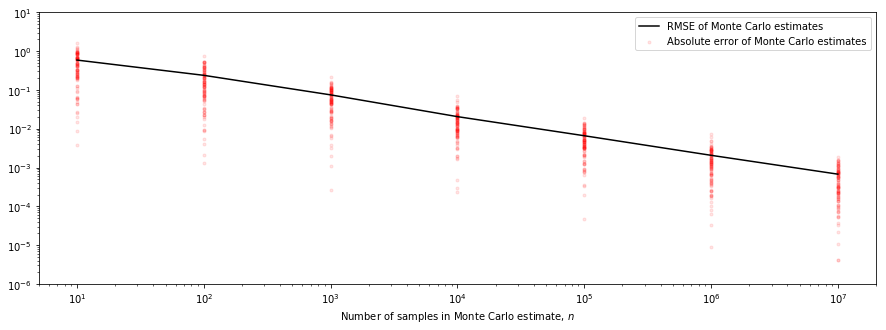

In [20]:
# Plot the results

_, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.xlabel(r'Number of samples in Monte Carlo estimate, $n$')
ax.scatter(kl_estimates[:, :, 0], 
           abs_error_of_kl_estimates,
           marker='.', color='red',
           alpha=0.1, label='Absolute error of Monte Carlo estimates')
ax.plot(n_grid, rmse_of_kl_estimates, color='k', label='RMSE of Monte Carlo estimates')
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_ylim([1e-6, 10])
ax.legend();

You can see that the gradient of the estimates' RMSE, an estimate of the MC estimator's standard devation, with respect to $n$ is $-\frac{1}{2}$. This is unsurprising: the estimator's variance is inversely proportional to $n$, so its log standard deviation is a linear function of $\log n$ with gradient $-\frac{1}{2}$. As $n$ increases, the Monte Carlo estimates approach the exact value of the KL divergence.

### Summary

You should now feel confident about how the Kullback-Leibler divergence is motivated and defined, what its key properties and why it is used in variational inference, and how it can be computed or estimated in TensorFlow.

### Further reading and resources

* TensorFlow documentation on `tfd.kl_divergence`: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/kl_divergence

## Appendix

#### Information gain, relative entropy, and Bayesian inference

This section provides further context for the Kullback-Leibler divergence. It is not essential, but it will give you a more complete understanding of what the divergence measures.

The Kullback-Leibler divergence has its origins in information theory. The Shannon entropy, defined as

\begin{equation}
    H(P) := E_{X \sim P(x)}[-\log P(X) ]
\end{equation}

is the greatest lower bound on the average number of nats ($\log 2$ nats are equal to $1$ bit) required to losslessly encode an observation sampled from from $P(x)$. This is an informal statement of a result known as the _source coding theorem_. $-\log P(x)$ is the number of bits used to encode $x$ in the lossless encoding scheme.

Say that a lossless compression algorithm instead encodes observations using a scheme that would be optimal for distribution $Q(x)$. Then the average number of of bits required to encode an observation sampled from $P(x)$ would be

\begin{equation}
    H(P, Q) := E_{X \sim P(x)}[-\log Q(X)]
\end{equation}

This is quantity is referred to as the _cross-entropy_ between $P$ and $Q$. Since $H(P)$ is the minimum average information for encoding observations from $P(x)$ by definition, it follows that $H(P, Q) \geq H(P)$.

The Kullback-Leibler divergence is defined as the average additional information required to encode observations from $P(x)$ using an optimal code for $Q(x)$:

\begin{align}
    D_{KL}(P \ || \ Q) &:= E_{X \sim P(x)}[-\log Q(X)] - E_{X \sim P(x)}[-\log P(X)] \\
                       &= H(P, Q) - H(P)
\end{align}

The KL divergence therefore tells us how inefficient the optimal coding scheme for $Q$ is when applied to data source $P$.

That KL divergence is the difference between a cross-entropy and a Shannon entropy sheds light on why the KL divergence has another moniker - _relative entropy_.

Alternatively, we might consider encoding observations in the context of Bayesian inference. Let $P(y)$ be the prior and $P(y|x)$ be the posterior. Then the Kullback-Leibler divergence

\begin{equation}
    D_{KL}(P(y|x) \ || \ P(y)) = E_{Y \sim P(y|x)}[-\log P(Y)] - E_{Y \sim P(y|x)}[-\log P(Y|x)]
\end{equation}

is the average number of bits saved if observations are encoded using an optimal code for the posterior rather than the prior. In this sense, the KL divergence tells us how much information is gained by conditioning on $X$.